# Классификация

Классификация - задача машинного обучения, в которой мы хотим научить модель распределять объекты по группам.

Например:

- предсказывать, в какую рубрику положить новость
- определять, положительный, отрицательный или нейтральный отзыв
- каков язык текста (метка языка - французский, английский и т.д.)
- к какому виду относится цветок
- на картинке зебра или лошадь

Классификация может быть бинарная (два класса) и множественная. Множественная можеж быть multiclass (один из множества классов) и multilabel (один объект может иметь несколько меток, например, тегов).

Задачу классификации можно решать разными методами:

**выделенные** посмотрим сегодня

- **логистическая регрессия** (logistic regression)
- метод K ближайших соседей (KNN - K nearest neighbours)
- **деревья решений** (decision tree)
- **случайный лес** (random forest)

## Датасет - новости

Мы будем использовать датасеты, которые доступны для простых проб работы в библиотеках. Первый - это датасет новостей, который есть в sklearn, есть 20 категорий, мы возьмем 4, по 2 похожие пары, чтобы делать бинарную классификацию (авто + мотоциклы VS бейсбол + хоккей).

Загружаем Counter, чтобы потом считать распределение классов.

In [1]:
from collections import Counter

Загружаем загрузчик датасета

In [2]:
from sklearn.datasets import fetch_20newsgroups

Загружаем деление на трейн и тест

In [3]:
from sklearn.model_selection import train_test_split

Скачиваем датасет, указываем те категории, которые хотим  (см. [подробнее](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset))

In [4]:
newsgroups = fetch_20newsgroups(
    categories=[
        'rec.autos',
        'rec.motorcycles',
        'rec.sport.baseball',
        'rec.sport.hockey'
    ])

In [5]:
newsgroups.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

Считаем баланс классов

In [6]:
Counter(newsgroups["target"])

Counter({0: 594, 3: 600, 2: 597, 1: 598})

In [7]:
print(newsgroups["data"][0])

From: swdwan@napier.uwaterloo.ca (Donald Wan)
Subject: $ 80 SVX OIL CHANGE
 
Organization: University of Waterloo
Lines: 17





 My friend brought a subaru SVX recently.  I had drove it for couples times and I
think its a great car, esp on snow.  However when she took it to a local Subaru
dealer for a oil change, the bill came out to be about 80 dollars.  The dealer
told us it is because to change the oil filter on a SVX it is necessary to
disassemble a metal cover under the engine and that took an hour of labour.
At first, we think we are being ripped off so she phone to a dealer in Toronto
but found out the they are charging roughly the same price.  So is there any
SVX owner out there that has the same problem ?  And if the oil change story is
true, then the engineer of Subaru looks pretty stubid to me. By the way, the car
looks great.

SWD Wan.




In [8]:
newsgroups["target_names"]

['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

Сохраняем тексты в data, ответы делаем True - спорт, False - авто

In [9]:
data = newsgroups["data"]
y = newsgroups["target"] > 1

Counter(y)

Counter({False: 1192, True: 1197})

Делим на трейн и тест

In [10]:
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=0)

В качестве признаков, по которым модель будет принимать решение, мы используем просто наличие слов (можно TF-IDF, обычно он используется)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

Бинарный - это есть / нет слово, нет разницы, сколько раз повторяется в тексте. Ограничение 10000 самых частотных слов. Лучше указывать стоп-слова.

In [12]:
cvec = CountVectorizer(binary=True, max_features=10000)
cvec.fit(data_train)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [13]:
X_train = cvec.transform(data_train).astype(int)
X_test = cvec.transform(data_test).astype(int)

Сохраним текстовые представления слов, чтобы потом понимать, какой признак где

In [14]:
feature_names = cvec.get_feature_names()
feature_names[-20:]

['zelepukin',
 'zen',
 'zephyr',
 'zeppelin',
 'zeppos',
 'zero',
 'zezel',
 'zhamnov',
 'zhitnik',
 'zhivov',
 'zmolek',
 'zombo',
 'zone',
 'zones',
 'zowie',
 'zubov',
 'zupcic',
 'zx',
 'zz',
 'zzzzzz']

## Логистическая регрессия

Логистическая регрессия - это модель, которая предсказывает вероятность наступления какого-то события. Часто используется для бинарной классификации (вероятность того, что объект принадлежит классу 1).

p = 0.1, скорее класс 0
p = 0.7, скорее класс 1

Логистическая регрессия в каком-то смысле похожа на линейную модель.

Мы пытаемся научиться предсказывать некоторое линейное выражение, которое после применения формулы будет давать наиболее точный ответ.

E - число Эйлера (2.71..)

$$p = \frac{1}{1 + e^{-1 * (b_0 + b_i * x_i)}}$$

Можно заметить, что у нас есть линейное выражение, которое может принимать разные значения, не только от 0 до 1 (см. линейные модели). Но дальше оно попадает в функцию сигмоиды, которая это значение преобразует так, чтобы оно было в пределах от 0 до 1, причем если оно очень большое или маленькое, то это уверенность в метке класса (около 0 или 1), если около нуля - промежуточный вариант.

$$f(x) = \frac{1}{1 + e^{-x}}$$

Например

$$f(0) = \frac{1}{1 + e^{-0}} = 1 / 2 = 0.5$$
$$f(0) = \frac{1}{1 + e^{-1}} = 1 / (1 + 1 / 2.71) = 0.73$$


<img src="https://upload.wikimedia.org/wikipedia/commons/a/ac/Logistic-curve.png">

Загружаем класс модели

In [15]:
from sklearn.linear_model import LogisticRegression

Задаем модель, обучаем. Если бы классы были не пополам, а несбалансированные (например, 30 / 70), мы бы указали балансировку классов при обучении (см. документацию)

In [16]:
model = LogisticRegression()

model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Загружаем метрики

In [17]:
from sklearn.metrics import accuracy_score, f1_score

Можно предсказать ответ

In [18]:
model.predict(X_test)[:5]

array([False,  True,  True, False, False])

А можно вероятности

In [19]:
model.predict_proba(X_test)[:5].round(2)

array([[0.92, 0.08],
       [0.03, 0.97],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.99, 0.01]])

Сохраняем ответы

In [20]:
y_pred = model.predict(X_test)

Считаем метрики 

In [21]:
accuracy_score(y_test, y_pred)

0.9874476987447699

In [22]:
f1_score(y_test, y_pred)

0.9874999999999999

**Коэффициенты**

У нас все одинаковые переменные, поэтому коэффициенты сравнимы

In [27]:
coefs = list(sorted(zip(model.coef_[0], feature_names)))

Авто

In [28]:
coefs[:5]

[(-1.5644632903146647, 'car'),
 (-1.4810356236285267, 'dod'),
 (-0.923258282350965, 'bike'),
 (-0.8821621479027447, 'cars'),
 (-0.7639429234685476, 'bmw')]

Спорт

In [29]:
coefs[-5:]

[(0.9604381476397577, 'players'),
 (1.1094995325918624, 'team'),
 (1.1216580759003025, 'hockey'),
 (1.1241598176982814, 'game'),
 (1.4075615669613628, 'baseball')]

Если бы мы хотели проверять не на отложенной выборке, а с помощью кросс-валидации, то можно вот так проверять модель) (см. вводную лекцию)

In [30]:
from sklearn.model_selection import cross_val_score

Смотрим на accuracy (по умолчанию) в каждом из делений

In [31]:
cross_val_score(LogisticRegression(), X=X_train, y=y_train, cv=10)

array([0.98958333, 0.9947644 , 0.97905759, 0.9947644 , 0.97382199,
       0.97905759, 0.98429319, 0.97905759, 0.98429319, 0.98429319])

## Деревья решений

Дерево решений - алгоритм, который позволяет решать задачи классификации и регрессии на основе обучения простым решениям (да/нет, больше/меньше).

Алгоритм находит признаки, которые позволяют разделить выборку так, чтобы новые части были более однородны. Затем эти части снова делятся на более однородные части.

Главным плюсом является интерпретируемость результатов.

<img src="https://miro.medium.com/max/1380/1*xzF10JmR3K0rnZ8jtIHI_g.png">

Источник: towardsdatascience

### Как находятся эти правила?

С помощью метрик, которые оценивают, насколько однородные и четкие группы получаются. 

Есть два критерия:

- критерий Джини
- энтропия (информационный прирост)

Чем более однороден каждый лист (последние группы), то есть в одно листе все или почти все элементы одного класса, тем лучше наше дерево делит пространство и предсказывает результат.

Но!

- Деревья могут подстраиваться под выборку и переобучаться.
- Небольшие изменения в данных могут сильно влиять на модель, особенно, если данных мало

С этой проблемой справляется случайный лес, то есть комбинация множества простых деревьев, которые строятся на части выборки или части признаков. Это позволяет делать модель более устойчивой.

In [32]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
model = DecisionTreeClassifier(max_depth=5)

model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [34]:
model.predict(X_test)[:5]

array([False, False,  True, False, False])

In [35]:
y_pred = model.predict(X_test)

In [36]:
accuracy_score(y_test, y_pred)

0.8117154811715481

In [37]:
f1_score(y_test, y_pred)

0.7715736040609137

Качество в нашем случае не очень, но всегда под разные задачи подходят какие-то модели лучше, какие-то нет

### Визуализация

Самое приятное - это визуализация и наглядность

In [38]:
from sklearn.tree import plot_tree

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

Задаем названия переменных (столбцов, указываем, чтобы цветом показывалась однородность в листьях). Чем темнее цвет, тем более "чистый" лист, то есть более однородный

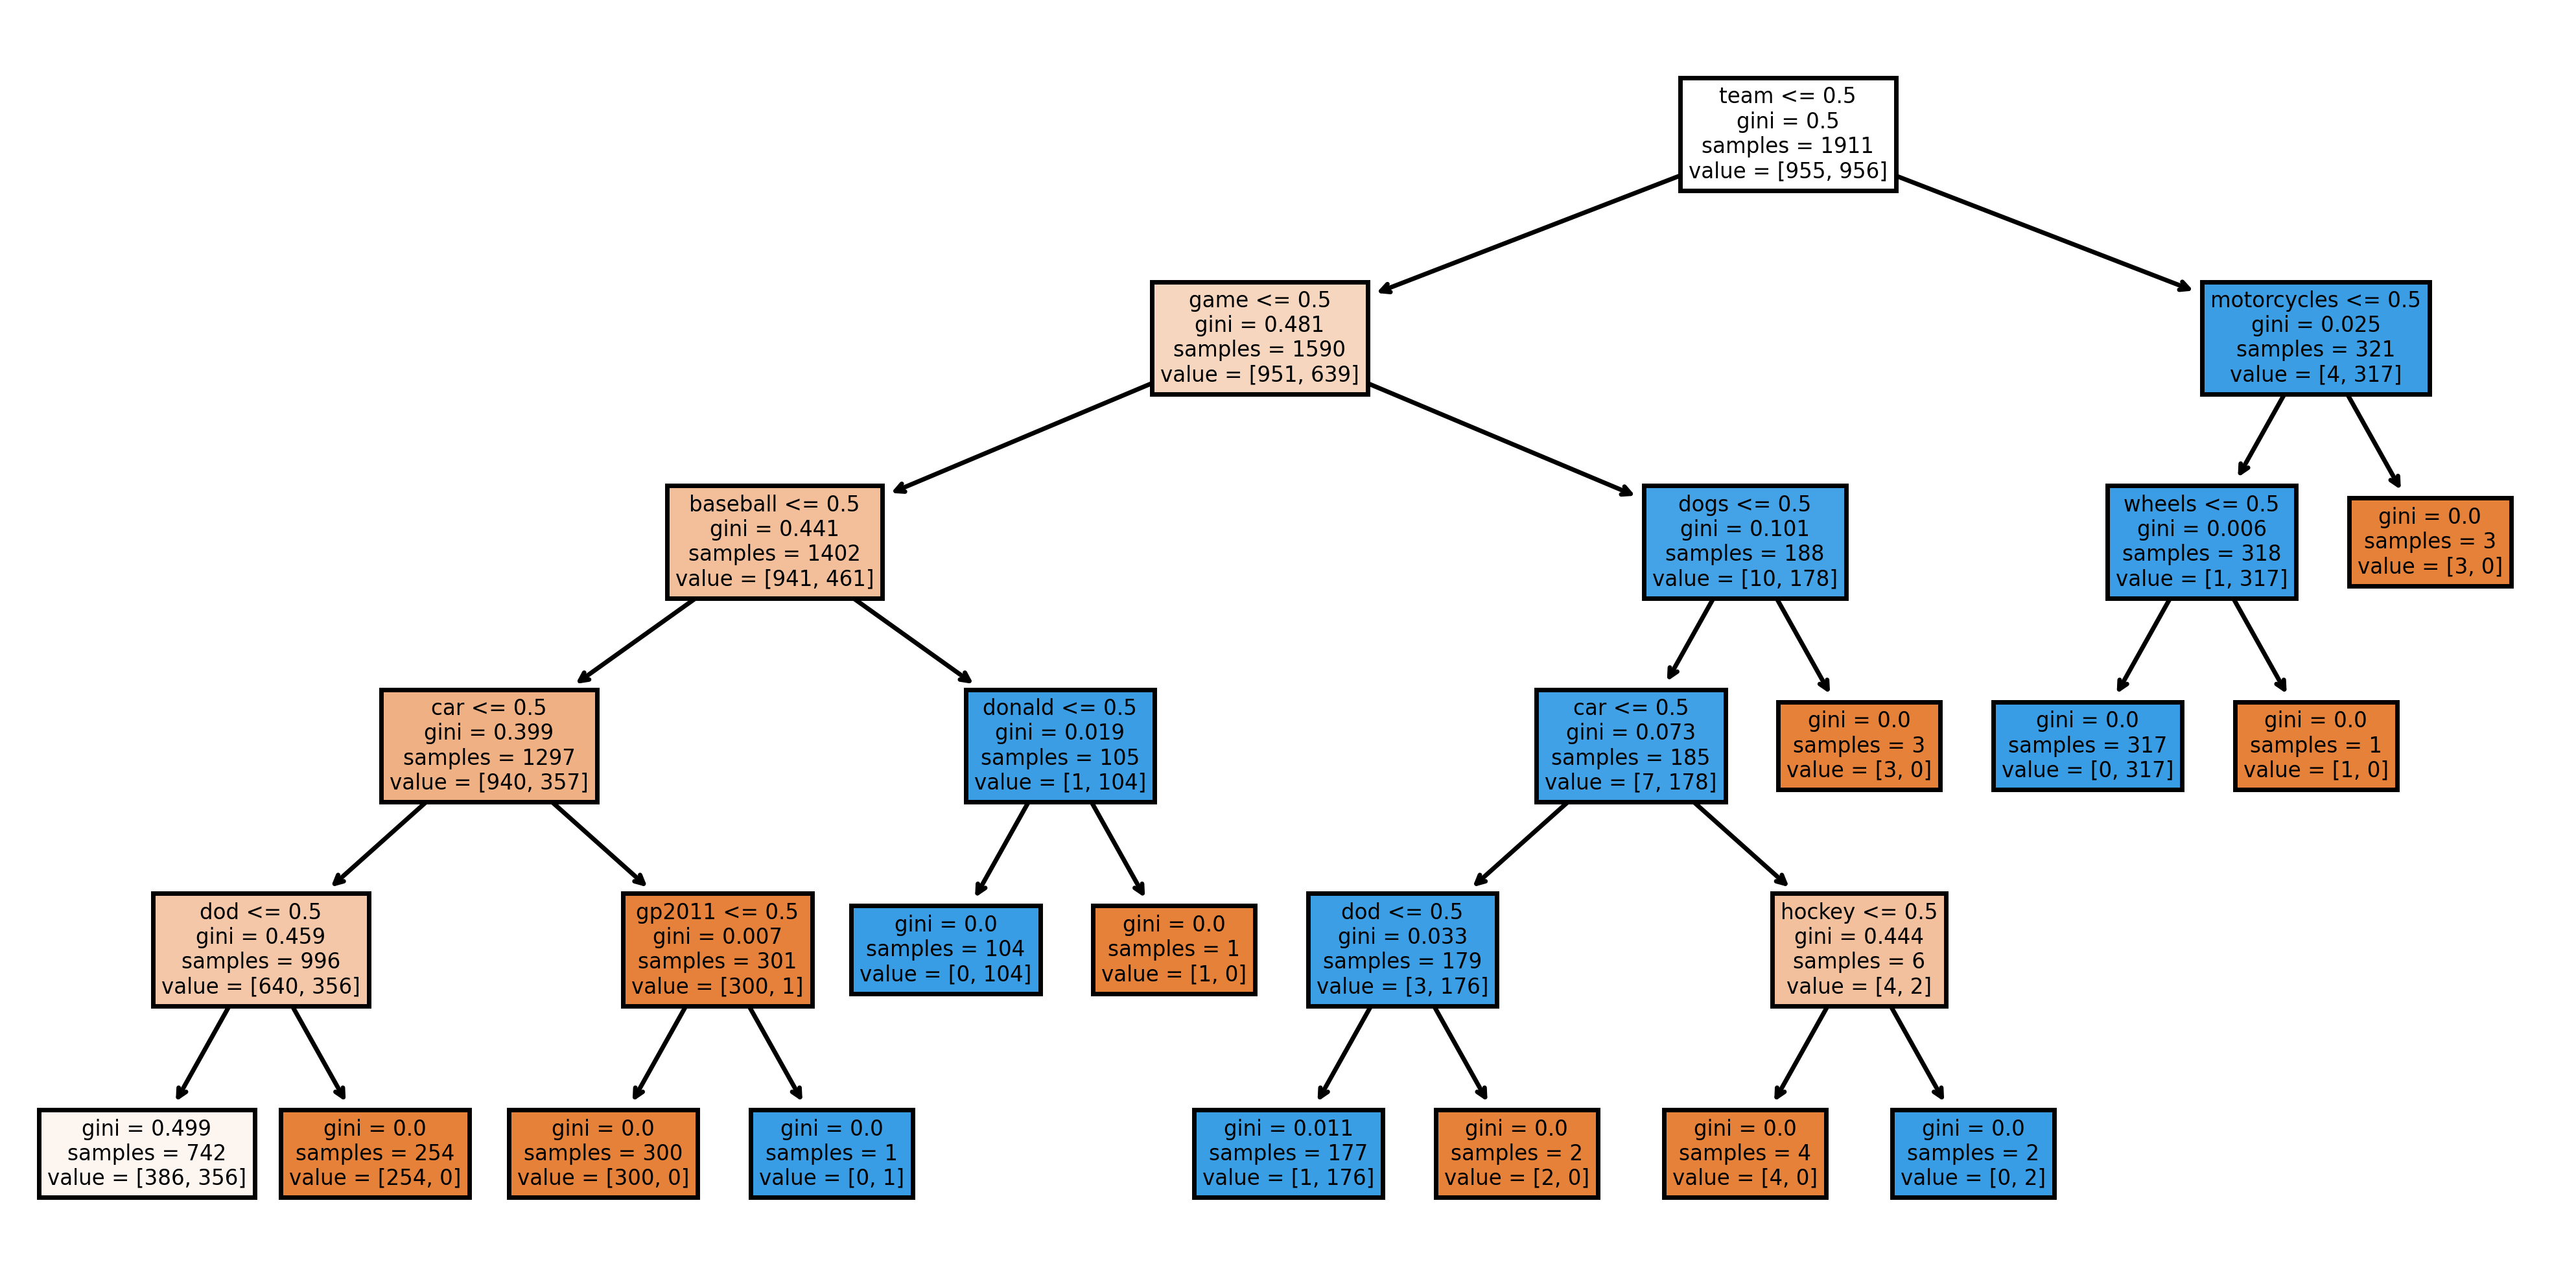

In [40]:
plt.figure(figsize=(10, 5), dpi=500)
plot_tree(model, feature_names=feature_names, filled=True);

In [41]:
from sklearn.ensemble import RandomForestClassifier

Указываем параметры:
    
- n_estimators - кол-во деревьев
- max_depth - максимальная глубина дерева (глубокие деревья могут переобучаться), лучше средние
- max_samples - максимальная доля выборки для одного дерева
- max_features - максимальное число признаков в одном дереве
- random_state - задание постоянной случайности

In [43]:
model = RandomForestClassifier(
    n_estimators=20, 
    max_depth=5,
    max_samples=0.5,
    max_features=1000,
    random_state=0, 
)

model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=1000,
                       max_leaf_nodes=None, max_samples=0.5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [44]:
y_pred = model.predict(X_test)

In [45]:
accuracy_score(y_test, y_pred)

0.9309623430962343

In [46]:
f1_score(y_test, y_pred)

0.9281045751633987

Качество стало лучше

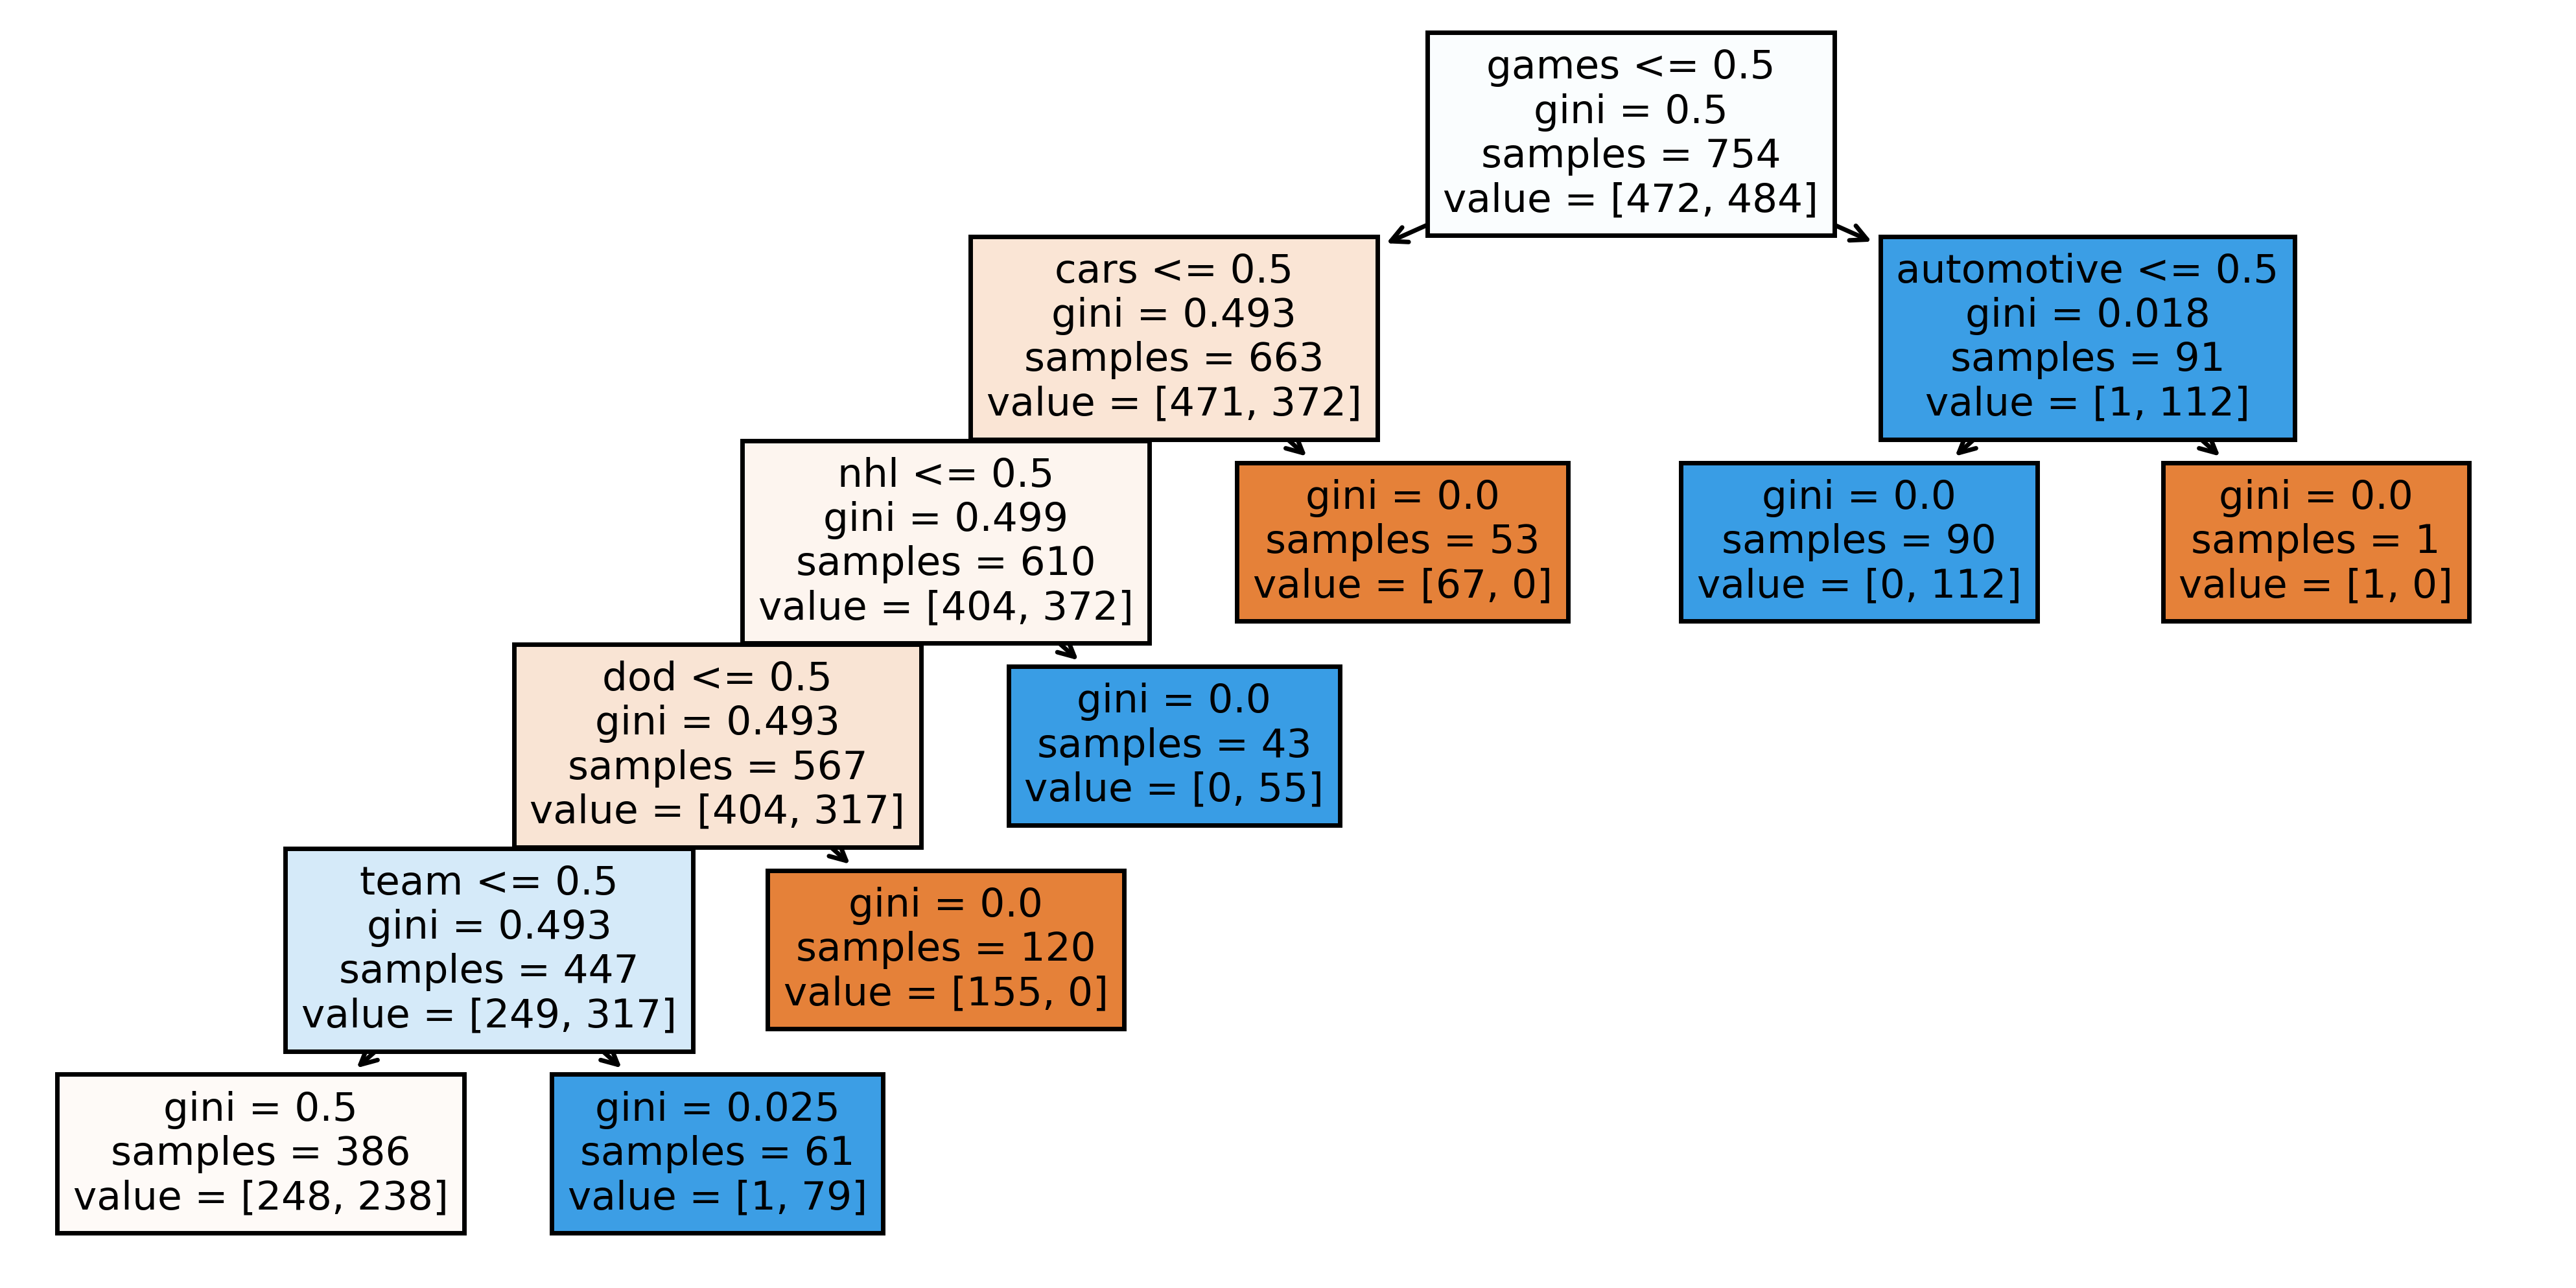

In [47]:
plt.figure(figsize=(10, 5), dpi=500)
plot_tree(model.estimators_[0], feature_names=feature_names, filled=True);

## Практика (немного классики)

Классический датасет для показа бинарной классификации - это Титаник, то есть предсказание, кто выживет, на основе некоторых данных

In [48]:
import seaborn as sns

In [49]:
dataset = sns.load_dataset("titanic")

[описание](https://data.world/nrippner/titanic-disaster-dataset)

- survival - Survival (0 = No; 1 = Yes)
- class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
- sex - Sex
- age - Age
- sibsp - Number of Siblings/Spouses Aboard
- parch - Number of Parents/Children Aboard
- ticket - Ticket Number
- fare - Passenger Fare
- cabin - Cabin
- embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
- boat - Lifeboat (if survived)

- alone

In [50]:
dataset.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [51]:
dataset = dataset[["pclass", "age", "sex", "sibsp", "parch", "survived"]].dropna()
y = dataset["survived"]
X = dataset.drop("survived", axis=1)

In [52]:
X["sex"] = X["sex"].apply(lambda x: 1 if "female" else 0)

In [53]:
X.head()

,pclass,age,sex,sibsp,parch
0,3,22.0,1,1,0
1,1,38.0,1,1,0
2,3,26.0,1,0,0
3,1,35.0,1,1,0
4,3,35.0,1,0,0


In [54]:
y.value_counts()

0    424
1    290
Name: survived, dtype: int64

### Задача


1. Постройте логистическую регрессию, задайте сбалансированные классы
2. Посмотрите на коэффициенты, какие влияют положительно (увеличивают шансы на выживание), какие наоборот
3. Посчитайте качество модели
4. Постройте решающее дерево
5. Визуализируйте
6. Какие закономерности видно? Какие пассажиры выживают? 
6. Посчитайте качество
7. Постройте случайный лес
8. Сравните качество с обычным деревом и логистической регрессией

### Логистическа регрессия

**Качество**

### Решающее дерево

**Качество**

**Визуализация**

### Случайный лес

**Качество**

**Общие выводы**